# Breast Cancer Prediction
The Wisconsin Breast Cancer Dataset consists of 699 samples with 30 features collected from a digitized image of a Fine Needle Aspirate (FNA) in order to diagnose whether or not a patient has cancer. In particular, a tumor may be classified as malignant (and therefore the cells inside the tumor are cancerous), or benign (in which, the tumor is normal.) An early diagnosis of such tumors is greatly important; when detected early, there is a 30% chance of effective treatment, compared to late stage treatment.

In this analysis, we will examine a few classification techniques to diagnostically predict whether or not a tumor is malignant or benign. We chose the following methods to conduct our analysis:
1. K-Nearest Neighbour (KNN)
2. Logistic Regression
3. Support Vector Machines (SVM)

*This analysis was originally done for a machine learning course [Winter 2020] I took in university, however I've added additional snippets to enrich the analysis.*

In [3]:
import IPython
import requests
import pandas as pd
import numpy as np

In [68]:
# URLs
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/breast-cancer-wisconsin/wdbc.data'

In [81]:
# Download cancer dataset
r = requests.get(DATA_URL)
open('breast-cancer.csv', 'wb').write(r.content)

# Add appropriate columns from notes
df = pd.read_csv('breast-cancer.csv',
                 names=['id', 'diagnosis', 'radius-mean', 'texture-mean', 'perimeter-mean', 'area-mean', 'smoothness-mean', 'compactness-mean', 'concavity-mean', 'concave-points-mean', 'symmetry-mean', 'fractal-dim-mean', 'radius-se', 'texture-se', 'perimeter-se', 'area-se', 'smoothness-se', 'compactness-se', 'concavity-se', 'concave-points-se', 'symmetry-se', 'fractal-dim-se', 'radius-worst', 'texture-worst', 'perimeter-worst', 'area-worst', 'smoothness-worst', 'compactness-worst', 'concavity-worst', 'concave-points-worst', 'symmetry-worst', 'fractal-dim-worst'],
                 na_values='?')

In [5]:
# Fixing the diagnosis to be categorical
df['diagnosis'] = df['diagnosis'].astype('category')

# Examining...
print(df.info())

# Check the df
df.head(5)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   id                    569 non-null    int64   
 1   diagnosis             569 non-null    category
 2   radius-mean           569 non-null    float64 
 3   texture-mean          569 non-null    float64 
 4   perimeter-mean        569 non-null    float64 
 5   area-mean             569 non-null    float64 
 6   smoothness-mean       569 non-null    float64 
 7   compactness-mean      569 non-null    float64 
 8   concavity-mean        569 non-null    float64 
 9   concave-points-mean   569 non-null    float64 
 10  symmetry-mean         569 non-null    float64 
 11  fractal-dim-mean      569 non-null    float64 
 12  radius-se             569 non-null    float64 
 13  texture-se            569 non-null    float64 
 14  perimeter-se          569 non-null    float64 
 15  area-s

,id,diagnosis,radius-mean,texture-mean,perimeter-mean,area-mean,smoothness-mean,compactness-mean,concavity-mean,concave-points-mean,...,radius-worst,texture-worst,perimeter-worst,area-worst,smoothness-worst,compactness-worst,concavity-worst,concave-points-worst,symmetry-worst,fractal-dim-worst
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


## Exploratory Data Analysis (EDA)

We can first look at the different distributions for each feature to get a general feel of the data.

In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

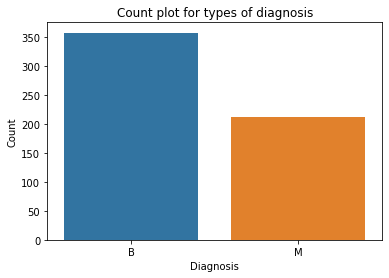

In [7]:
# Simple counts per bucket (only 2 for this category)
sns.countplot(x='diagnosis', data=df)
plt.ylabel('Count')
plt.xlabel('Diagnosis')
plt.title('Count plot for types of diagnosis')
plt.show()

Since the rest of our features are continuous, we can use histograms to visualize their distributions.

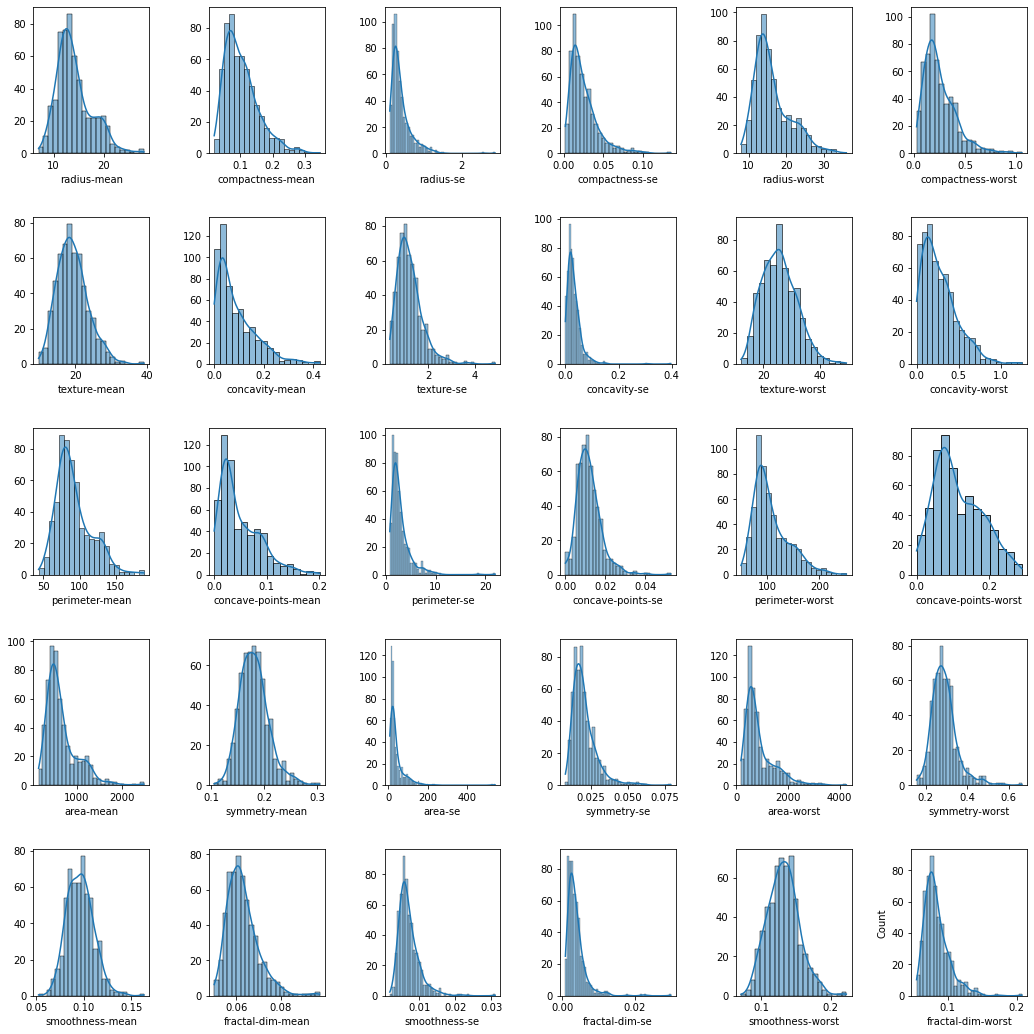

In [8]:
# Plot distribution of continuous variables using histogram
# from https://tryolabs.com/blog/2017/03/16/pandas-seaborn-a-guide-to-handle-visualize-data-elegantly/
fig, axes = plt.subplots(5, 6, figsize=(15, 15))
for i, col in enumerate(df.columns[2:]):
    sns.histplot(ax=axes[i % 5, i // 5], data=df[col], kde=True)

# Remove y labels
for ax in axes.flat:
    ax.set_ylabel('')

# Add padding
fig.tight_layout(pad=3.0)

plt.ylabel('Count')
plt.show()

We can also attempt to look for ways to reduce the dimensions of our features and see if any hyperplane/decision-boundary exists between the two labels. Two means of doing this are *multidimensional scaling* (MDS) and *principal compenent analysis* (PCA).

The basic jist of how **MDS** works is it computes the distances of each sample based on some distance/dissimilarity metric, usually by computing the pairwise distances between a given sample's feature value and another, and summing each component's distance.

We use classical MDS in the cell below.

In [9]:
from sklearn.metrics import pairwise_distances
from sklearn.preprocessing import scale, StandardScaler
from sklearn.manifold import MDS

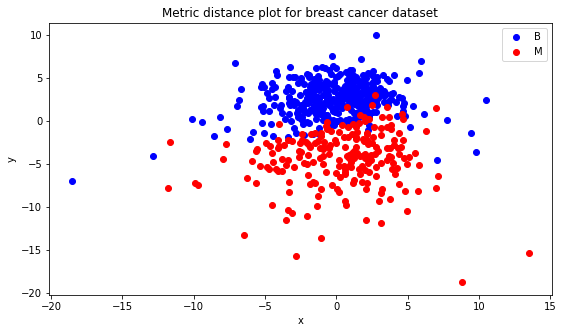

In [10]:
# Remove categorical
x = df.drop(['id', 'diagnosis'], axis=1)
x = scale(x) # Normalize

# Compute euclidean for each pair
dis = pairwise_distances(x)

# Classical MDS
# TODO: Look more in-depth into this (in particular, why do we need a seed)
mds = MDS(n_components=2, dissimilarity='precomputed')
mds_plots = mds.fit_transform(dis)

cdict = {'M': 'red', 'B': 'blue'}
classes = np.array(df['diagnosis'].to_list())

# Plotting
fig, ax = plt.subplots(figsize=(9, 5))
for g in np.unique(classes):
    idx = np.where(classes == g)
    ax.scatter(mds_plots[idx, 0], mds_plots[idx, 1], c=cdict[g], label=g)
plt.title('Metric distance plot for breast cancer dataset')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()
plt.show()

From the above MDS plot, we can note that the data looks to be linearly seperable with very minimal overlap between points. Therefore, most methods where a hyperplane can be derived from should yield very good results.

We can also use **PCA** to decompose the data into a 2D space, finding a projection that maximizes the variance between the points.

In [50]:
from sklearn.decomposition import PCA

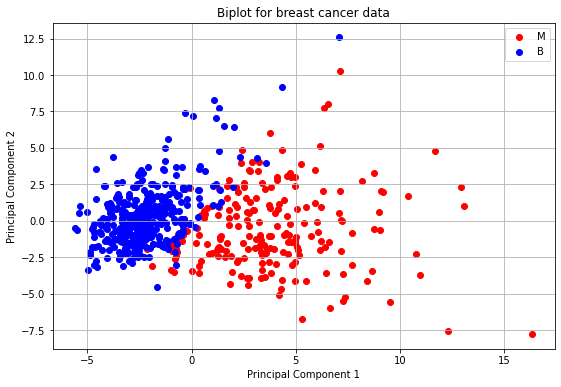

In [46]:
# Step 0: Normalize data (done in cell above!)

# Perform PCA with only 2 components
pca = PCA(n_components=2)
pca.fit(x)
x_new = pca.transform(x)

# Create dataframes for easier plotting (pc1, pc2, diagnosis)
p_df = pd.DataFrame(data=x_new, columns=['pc1', 'pc2'])
p_df = pd.concat([p_df, df['diagnosis']], axis=1)

targets = ['M', 'B']
colors = ['r', 'b']

# Plot PCA
fig = plt.figure(figsize = (9, 6))
ax = fig.add_subplot(1, 1, 1) 

for target, color in zip(targets, colors):
    idx = np.where(np.array(p_df['diagnosis'].to_list()) == target)
    ax.scatter(p_df.loc[idx, 'pc1'], p_df.loc[idx, 'pc2'], c=color)

ax.legend(targets)
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Biplot for breast cancer data')
ax.grid()
plt.show()

# Classification
Before we spend any time with various classification techniques, lets first implement a simple baseline classifier for benchmarking.

We use the *train-validation-test framework*, splitting the data into 80% labelled, and 20% test. We then further split the labelled data using *10-fold cross-validation* to compute hyperparameter values that yield the best performance among the folds.

We use the *F1-measure* to evaluate performance of our classifier, given that **we care more about the false negatives** since patients with cancer who test negative fail to follow-up on further tests.

In [19]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from sklearn.metrics import make_scorer

In [20]:
# Split data using 80:20 split
X_label, X_test, y_label, y_test = train_test_split(x, df['diagnosis'], test_size=0.20)

# f1 metric
f1_scorer = make_scorer(f1_score, pos_label='M')

## Baseline Classifier
For this problem, we chose to use a classifier that generates predictions sampled from a uniform distribution. The results from this kind of classifier fit better than a "majority guess" classifier in that because we use the *F1-measure* described above as our evaluation metric, the classifier would have a poor performance otherwise.

In [25]:
from sklearn.dummy import DummyClassifier
from sklearn.metrics import plot_confusion_matrix

F1 score: 0.3877551020408163


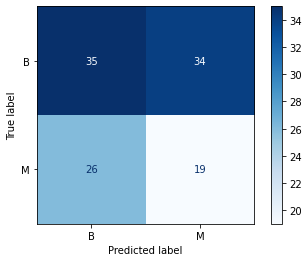

In [72]:
# Predict using predictions generated from uniform random distribution
base = DummyClassifier(strategy="uniform", random_state=123)
base.fit(X_label, y_label)
results = base.predict(X_test)

# f1 score
print('F1 score: {}'.format(f1_score(y_test, results, pos_label='M')))

# Plot confusion matrix
disp = plot_confusion_matrix(base, X_test, y_test, cmap=plt.cm.Blues)

Any model that can achieve a F1 score higher than the above results will be regarded as substantial.

## K-Nearest Neighbours
For this method, we classify based on the most common class among its k-nearest neighbours based on some criteria.

Using the *train-validation-test framework*, we extract the best hyperparameter value from 10-fold cross validation using two methods: 
1. Use **grid search** with takes the cross-product of all parameters specified, outputting the best combination of such parameters.
2. Use **randomized search** to sample from the grid of parameters.

In [74]:
from sklearn.neighbors import KNeighborsClassifier

KNN accuracy: 0.9649122807017544 best k: 3


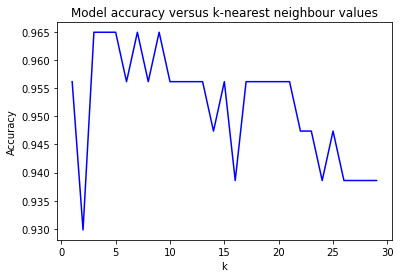

In [77]:
# First try: Find the hyperparameter k iteratively 
# and plot accuracies

# k from 1 to 30
k = [x for x in range(1, 30)]

knn_accs = []
best_acc = 0
best_k = None

# One run over train-test split
for i in k:
    knn = KNeighborsClassifier(n_neighbors=i)
    knn.fit(X_label, y_label)
    acc = knn.score(X_test, y_test)
    knn_accs.append(acc)
    if acc > best_acc:
        best_acc = acc
        best_k = i

# Best model
print('KNN accuracy: {} best k: {}'.format(best_acc, best_k))

# KNN accuracy based on different hyperparameter k values
plt.figure()
plt.title("Model accuracy versus k-nearest neighbour values")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.plot(k, knn_accs, color="blue")
plt.show()

In [14]:
from sklearn.model_selection import GridSearchCV

In [90]:
# Grid Search using 10-fold cross-validation

param_grid = {'n_neighbors': np.arange(1, 30),
          'weights': ['uniform', 'distance'],
           'metric': ['manhattan', 'euclidean']}

# KNN
bc_knn = KNeighborsClassifier()
bc_knncv = GridSearchCV(bc_knn, param_grid, cv=10, scoring=f1_scorer)
bc_knncv.fit(X_label, y_label)

# Scores and k for best model from hyperparameter tuning
print('Best k: {}'.format(bc_knncv.best_params_['n_neighbors']))
print('Best weights: {}'.format(bc_knncv.best_params_['weights']))
print('Best metric: {}'.format(bc_knncv.best_params_['metric']))
print('Validation F1-measure: {}'.format(bc_knncv.best_score_))

Best k: 8
Best weights: distance
Best metric: manhattan
Validation F1-measure: 0.9594280087401529


For monitoring model performance, we can look at the *learning curves* of the training and validation sets to diagnose whether our model is underfitting or overfitting. The *scalability* of the model is also plotted to show how much time is required to train with various sizes (this isn't as important, since for this analysis we stuck to 100 epochs). Finally, we plot the *performance* of the estimators, i.e., fit times versus scores.

Source: https://scikit-learn.org/stable/auto_examples/model_selection/plot_learning_curve.html

In [15]:
from sklearn.model_selection import learning_curve

In [16]:
def plot_learning_curve(estimator, title, X, y, axes=None, ylim=None, cv=None,
                        n_jobs=None, train_sizes=np.linspace(.1, 1.0, 5)):
    if axes is None:
        _, axes = plt.subplots(1, 3, figsize=(20, 5))

    axes[0].set_title(title)
    if ylim is not None:
        axes[0].set_ylim(*ylim)
    axes[0].set_xlabel("Training examples")
    axes[0].set_ylabel("Score")

    train_sizes, train_scores, test_scores, fit_times, _ = \
        learning_curve(estimator, X, y, cv=cv, n_jobs=n_jobs,
                       train_sizes=train_sizes,
                       return_times=True)
    train_scores_mean = np.mean(train_scores, axis=1)
    train_scores_std = np.std(train_scores, axis=1)
    test_scores_mean = np.mean(test_scores, axis=1)
    test_scores_std = np.std(test_scores, axis=1)
    fit_times_mean = np.mean(fit_times, axis=1)
    fit_times_std = np.std(fit_times, axis=1)

    # Plot learning curve
    axes[0].grid()
    axes[0].fill_between(train_sizes, train_scores_mean - train_scores_std,
                         train_scores_mean + train_scores_std, alpha=0.1,
                         color="r")
    axes[0].fill_between(train_sizes, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1,
                         color="g")
    axes[0].plot(train_sizes, train_scores_mean, 'o-', color="r",
                 label="Training score")
    axes[0].plot(train_sizes, test_scores_mean, 'o-', color="g",
                 label="Cross-validation score")
    axes[0].legend(loc="best")

    # Plot n_samples vs fit_times
    axes[1].grid()
    axes[1].plot(train_sizes, fit_times_mean, 'o-')
    axes[1].fill_between(train_sizes, fit_times_mean - fit_times_std,
                         fit_times_mean + fit_times_std, alpha=0.1)
    axes[1].set_xlabel("Training examples")
    axes[1].set_ylabel("fit_times")
    axes[1].set_title("Scalability of the model")

    # Plot fit_time vs score
    axes[2].grid()
    axes[2].plot(fit_times_mean, test_scores_mean, 'o-')
    axes[2].fill_between(fit_times_mean, test_scores_mean - test_scores_std,
                         test_scores_mean + test_scores_std, alpha=0.1)
    axes[2].set_xlabel("fit_times")
    axes[2].set_ylabel("Score")
    axes[2].set_title("Performance of the model")

    return plt


Test accuracy: 0.9649122807017544


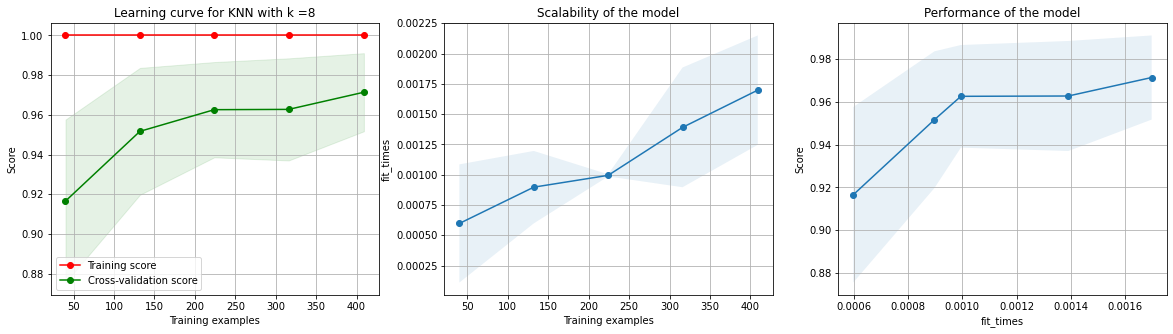

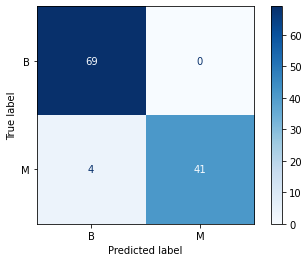

In [88]:
# Plot learning rate of best model
title = 'Learning curve for KNN with k =' + str(bc_knncv.best_params_['n_neighbors'])
plot_learning_curve(bc_knncv.best_estimator_, title, X_label, y_label, cv=10)

# Test accuracy
print('Test accuracy: {}'.format(bc_knncv.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix on the test set
disp = plot_confusion_matrix(bc_knncv.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)

In [17]:
from sklearn.model_selection import RandomizedSearchCV

Best k: 3
Best weights: uniform
Best metric: manhattan
Validation F1-measure: 0.9505153527686734
Test accuracy: 0.9736842105263158


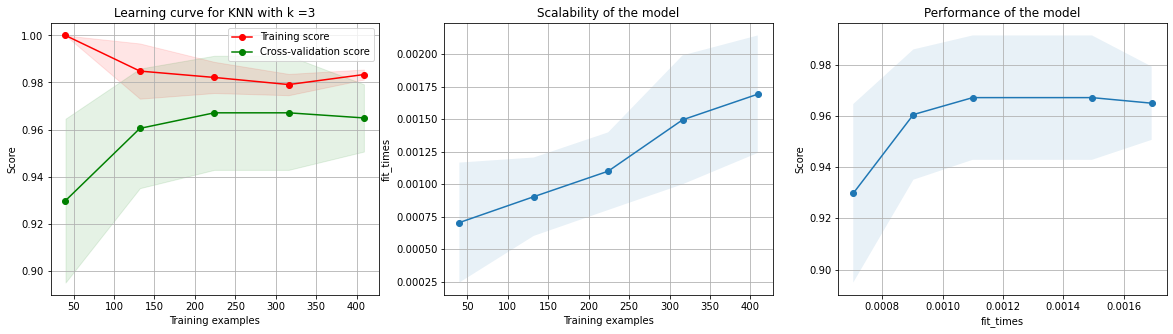

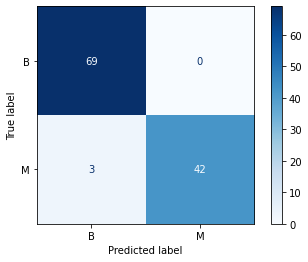

In [93]:
# Randomized Search

bc_knncv_rs = RandomizedSearchCV(bc_knn, param_grid, cv=10, scoring=f1_scorer, random_state=123)
bc_knncv_rs.fit(X_label, y_label)

print('Best k: {}'.format(bc_knncv_rs.best_params_['n_neighbors']))
print('Best weights: {}'.format(bc_knncv_rs.best_params_['weights']))
print('Best metric: {}'.format(bc_knncv_rs.best_params_['metric']))
print('Validation F1-measure: {}'.format(bc_knncv_rs.best_score_))

# Plot learning rate of best model
title = 'Learning curve for KNN with k =' + str(bc_knncv_rs.best_params_['n_neighbors'])
plot_learning_curve(bc_knncv_rs.best_estimator_, title, X_label, y_label, cv=10)

print('Test accuracy: {}'.format(bc_knncv_rs.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix on the test set
disp = plot_confusion_matrix(bc_knncv_rs.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)

We get the best performing KNN method to have k=3 using uniform weights and manhattan distance metric, with a test accuracy of about 97%.

## Logistic Regression
Next, we turn to *logistic regression* to classify the tumors. How this works is that we essentially squash the linear function $f(x; \theta) = \theta^\intercal x$ to output values between 0 and 1, using the sigmoid function, defined as $\sigma(z)$, where $z$ is the linear function. Thus, $\sigma(z)$ denotes the estimated probability that the tumor is malignant, and we can tweak the parameter weights to find the best fitting hyperplane.

In [95]:
from sklearn.linear_model import LogisticRegression

In [110]:
# Suppress convergence warnings (maybe need to up tolerance??)
# TODO
from warnings import filterwarnings
filterwarnings('ignore')

Best C: 2.976351441631316
Best solver: newton-cg
Validation F1-measure: 0.9751548317274125
Test accuracy: 0.956140350877193


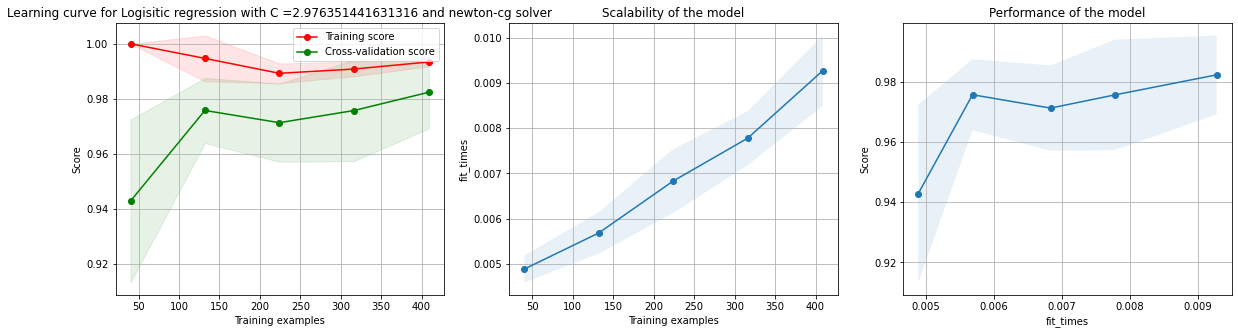

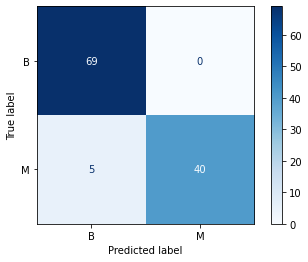

In [115]:
# Trying out l1-penalty, l2-penalty on 4000 epochs
lr = LogisticRegression(max_iter=4000)
param_grid = {'C': np.logspace(-3, 3, 20),
              'solver': ['newton-cg', 'lbfgs', 'liblinear', 'sag']}

# 10-fold cross-validation
lr_cv = GridSearchCV(lr, param_grid, cv=10, scoring=f1_scorer)
lr_cv.fit(X_label, y_label)

# Scores and k for best model from hyperparameter tuning
print('Best C: {}'.format(lr_cv.best_params_['C']))
print('Best solver: {}'.format(lr_cv.best_params_['solver']))
print('Validation F1-measure: {}'.format(lr_cv.best_score_))

# Plot learning rate of best model
title="Learning curve for Logisitic regression with C =" + str(lr_cv.best_params_['C']) + " and " + str(lr_cv.best_params_['solver']) + " solver"
plot_learning_curve(lr_cv.best_estimator_, title, X_label, y_label, cv=10)

print('Test accuracy: {}'.format(lr_cv.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix on test set
disp = plot_confusion_matrix(lr_cv.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)

Best C: 1.438449888287663
Best solver: sag
Validation F1-measure: 0.9690830848468419
Test accuracy: 0.9649122807017544


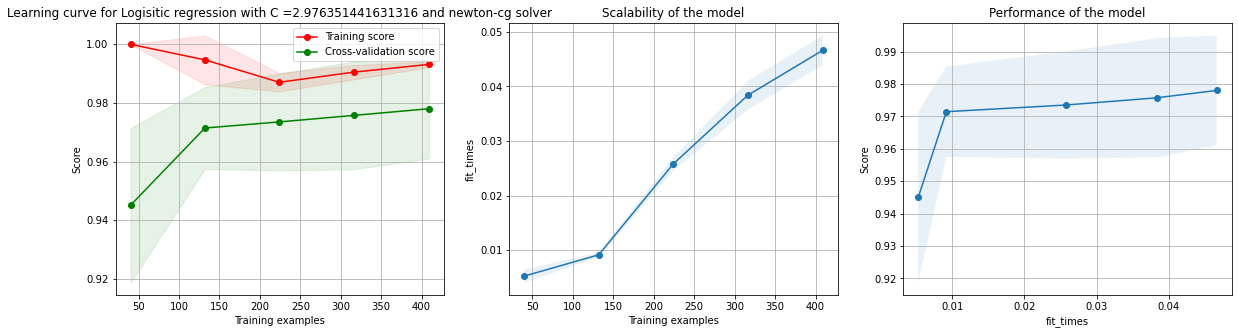

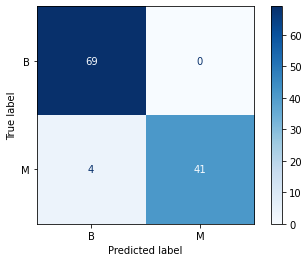

In [116]:
# Randomized Search
lr_cv_rs = RandomizedSearchCV(lr, param_grid, cv=10, scoring=f1_scorer, random_state=123)
lr_cv_rs.fit(X_label, y_label)

print('Best C: {}'.format(lr_cv_rs.best_params_['C']))
print('Best solver: {}'.format(lr_cv_rs.best_params_['solver']))
print('Validation F1-measure: {}'.format(lr_cv_rs.best_score_))

# Plot learning rate of best model
title = 'Learning curve for Logisitic regression with C =' + \
        str(lr_cv.best_params_['C']) + \
        ' and ' + str(lr_cv.best_params_['solver']) + ' solver'
plot_learning_curve(lr_cv_rs.best_estimator_, title, X_label, y_label, cv=10)

print('Test accuracy: {}'.format(lr_cv_rs.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix on test set
disp = plot_confusion_matrix(lr_cv_rs.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)

We get the best performing logistic regression method to have a test accuracy around 96% using the stochastic avg. gradient method for optimization with regularization strength at approx. 1.4.

## Support Vector Machines
Finally, we use *Support Vector Machines* as a means of classification. Essentially, SVMs are similar to logistic regression, where instead of maximizing the class probabilities, we maximize the margins between the closest points, i.e., the support vectors, to the decision plane.

We've seen from using PCA and MDS that the data looks to be linearly separable, so performing SVM classification without a kernel will probably yield good results. We can show this by also using a non-linear kernel (RBF/Guassian, for instance) and comparing the results between the two.

In [12]:
from sklearn.svm import SVC

Best params: {'C': 0.1623776739188721, 'kernel': 'linear'}, Best score: 0.9636252228163993
Test accuracy: 0.9912280701754386


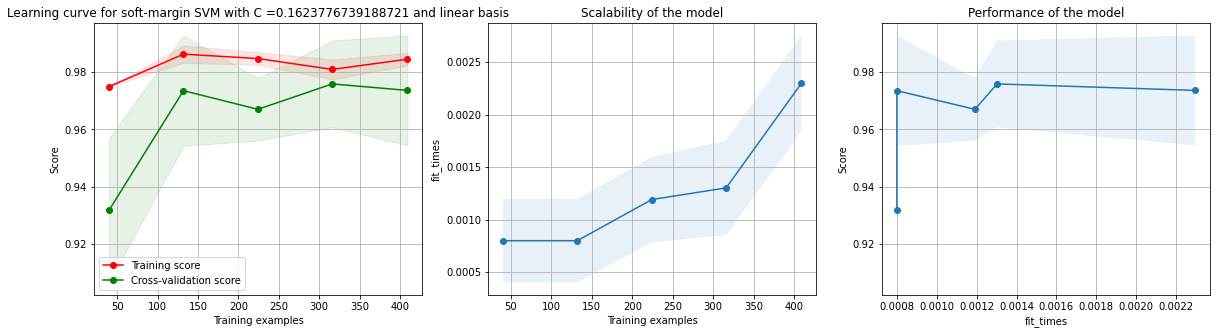

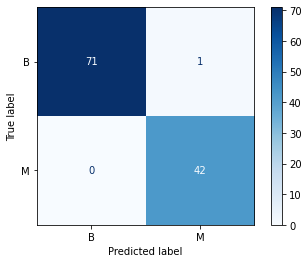

In [26]:
# Grid Search
params = [{'kernel': ['rbf'], 'gamma': [1e-3, 1e-4],
                     'C': np.logspace(-3, 3, 20)},
                    {'kernel': ['linear'], 'C': np.logspace(-3, 3, 20)}]

svc = SVC()
svm_cv = GridSearchCV(svc, params, cv=10, scoring=f1_scorer)
svm_cv.fit(X_label, y_label)

# Best parameters and F1-measure
print('Best params: {}, Best score: {}'.format(svm_cv.best_params_, svm_cv.best_score_))

# Plot learning rate of best model
title = 'Learning curve for soft-margin SVM with C =' + \
         str(svm_cv.best_params_['C']) + \
         ' and ' + str(svm_cv.best_params_['kernel']) + \
         ' basis'
plot_learning_curve(svm_cv.best_estimator_, title, X_label, y_label, cv=10)

print('Test accuracy: {}'.format(svm_cv.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix
disp = plot_confusion_matrix(svm_cv.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)


Best params: {'kernel': 'rbf', 'gamma': 0.0001, 'C': 1000.0}, Best score: 0.9605949197860962
Test accuracy: 0.9912280701754386


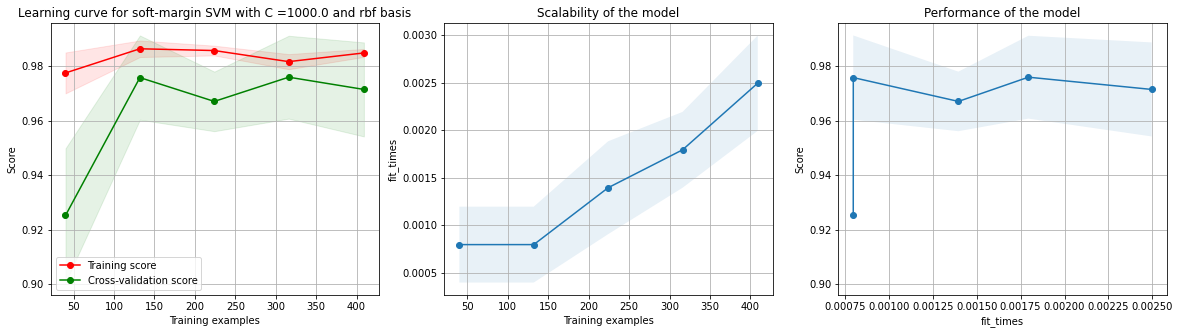

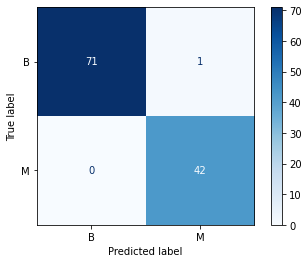

In [29]:
# Randomized Search
svm_cv_rs = RandomizedSearchCV(svc, params, cv=10, scoring=f1_scorer, random_state=123)
svm_cv_rs.fit(X_label, y_label)

print('Best params: {}, Best score: {}'.format(svm_cv_rs.best_params_, svm_cv_rs.best_score_))

# Plot learning rate of best model
title = 'Learning curve for soft-margin SVM with C =' + \
         str(svm_cv_rs.best_params_['C']) + \
         ' and ' + str(svm_cv_rs.best_params_['kernel']) + \
         ' basis'
plot_learning_curve(svm_cv_rs.best_estimator_, title, X_label, y_label, cv=10)

print('Test accuracy: {}'.format(svm_cv_rs.best_estimator_.score(X_test, y_test)))

# Plot confusion matrix
disp = plot_confusion_matrix(svm_cv_rs.best_estimator_, X_test, y_test,
                            cmap=plt.cm.Blues)

From the above analysis, the linear kernel SVM gets the same accuracy in the test setting compared to the non-linear SVM as expected, with both models achieving accuracies around 99%. 

# Conclusion
From our evaluation of the three models, we can conclude that *SVM* and the *logistic regression* are both adequate classification methods for determining whether or not a tumor is malignant or benign, yielding good F1 scores. However, all three models in general produce high scores, especially compared to the dummy classifier. Therefore, each model is substantial and can be used for the breast cancer problem setting given the same features.